# Import Relevant Libraries and Load in Merged Datasets

In [135]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

In [4]:
df = pd.read_csv('data/merged_data.csv')

/Users/jamiecarnevale/miniconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (10,21,30,63,97,99,118,119,120,122,126,127,128,131,133,136,137,139,149) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Data Cleaning

In [5]:
#first taking a look at all the different columns, null value counts, and datatypes
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731907 entries, 0 to 731906
Data columns (total 150 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     731907 non-null  int64  
 1   PERSON_ID                      731907 non-null  object 
 2   PERSON_TYPE                    731907 non-null  object 
 3   CRASH_RECORD_ID                731907 non-null  object 
 4   RD_NO_x                        727570 non-null  object 
 5   VEHICLE_ID_x                   725151 non-null  float64
 6   CRASH_DATE_x                   731907 non-null  object 
 7   SEAT_NO                        60155 non-null   float64
 8   CITY                           460748 non-null  object 
 9   STATE                          459075 non-null  object 
 10  ZIPCODE                        422795 non-null  object 
 11  SEX                            727658 non-null  object 
 12  AGE                          

In [6]:
#checking out what those areas mean
df.iloc[:,100:120].head()

,TOWED_BY,TOWED_TO,AREA_00_I,AREA_01_I,AREA_02_I,AREA_03_I,AREA_04_I,AREA_05_I,AREA_06_I,AREA_07_I,AREA_08_I,AREA_09_I,AREA_10_I,AREA_11_I,AREA_12_I,AREA_99_I,FIRST_CONTACT_POINT,CMV_ID,USDOT_NO,CCMC_NO
0,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIDE-RIGHT-FRONT,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REAR,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,FRONT-LEFT,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,UNKNOWN,NaN,NaN,NaN


### let's drop all columns that have less than 250k nonnull values

In [322]:
#taking a look at all the columns that will be dropped
df.columns[df.notna().sum() < 250000]

Index(['SEAT_NO', 'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO', 'PEDPEDAL_ACTION',
       'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'BAC_RESULT VALUE',
       'CELL_PHONE_USE', 'CRASH_DATE_EST_I', 'LANE_CNT',
       'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_PASSENGERS', 'CMRC_VEH_I',
       'TOWED_I', 'FIRE_I', 'EXCEED_SPEED_LIMIT_I', 'TOWED_BY', 'TOWED_TO',
       'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I', 'AREA_04_I',
       'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I', 'AREA_09_I',
       'AREA_10_I', 'AREA_11_I', 'AREA_12_I', 'AREA_99_I', 'CMV_ID',
       'USDOT_NO', 'CCMC_NO', 'ILCC_NO', 'COMMERCIAL_SRC', 'GVWR',
       'CARRIER_NAME', 'CARRIER_STATE', 'CARRIER_CITY', 'HAZMAT_PLACARDS_I',
       'HAZMAT_NAME', 'UN_NO', 'HAZMAT_PRESENT_I', 'HAZMAT_REPORT_I',
       'HAZMAT_REPORT_NO', 'MCS_REPORT_I', 'MCS_REPORT_NO',
       

In [8]:
# dropping all columns that have less than 250k non null values in new dataframe df1
colstodrop = df.columns[df.notna().sum() < 250000]
df1 = df.drop(colstodrop, axis = 1)

In [10]:
#just checking to see what this column is
df1['PERSON_TYPE'].value_counts()

DRIVER                 665215
PASSENGER               60155
BICYCLE                  3524
PEDESTRIAN               2403
NON-MOTOR VEHICLE         464
NON-CONTACT VEHICLE       146
Name: PERSON_TYPE, dtype: int64

In [323]:
#checking out example values for some of the columns
df1.head()
#noticed that there were a lot of irrelevant columns like rd number

,Unnamed: 0,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,RD_NO_x,VEHICLE_ID_x,CRASH_DATE_x,CITY,STATE,ZIPCODE,...,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,OCCUPANT_CNT,FIRST_CONTACT_POINT
0,0,O749947,DRIVER,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,834816.0,09/28/2019 03:30:00 AM,CHICAGO,IL,60651,...,CIVIC,IL,2016.0,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,1.0,FRONT
1,1,O871921,DRIVER,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,JD208731,827212.0,04/13/2020 10:50:00 PM,CHICAGO,IL,60620,...,ENCORE,IL,NaN,NONE,PASSENGER,PERSONAL,W,STRAIGHT AHEAD,1.0,SIDE-RIGHT-FRONT
2,2,O10018,DRIVER,71162af7bf22799b776547132ebf134b5b438dcf3dac6b...,HY484534,9579.0,11/01/2015 05:00:00 AM,NaN,NaN,NaN,...,UNKNOWN,XX,NaN,NONE,PASSENGER,PERSONAL,E,BACKING,1.0,REAR
3,3,O10038,DRIVER,c21c476e2ccc41af550b5d858d22aaac4ffc88745a1700...,HY484750,9598.0,11/01/2015 08:00:00 AM,NaN,NaN,NaN,...,GRAND CARAVAN,IL,2012.0,NONE,PASSENGER,NOT IN USE,N,PARKED,0.0,FRONT-LEFT
4,4,O10039,DRIVER,eb390a4c8e114c69488f5fb8a097fe629f5a92fd528cf4...,HY484778,9600.0,11/01/2015 10:15:00 AM,NaN,NaN,NaN,...,UNKNOWN,XX,NaN,UNKNOWN,UNKNOWN/NA,UNKNOWN/NA,UNKNOWN,UNKNOWN/NA,1.0,UNKNOWN


In [12]:
#again looking at the data after the limited data columns were filtered out
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731907 entries, 0 to 731906
Data columns (total 76 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     731907 non-null  int64  
 1   PERSON_ID                      731907 non-null  object 
 2   PERSON_TYPE                    731907 non-null  object 
 3   CRASH_RECORD_ID                731907 non-null  object 
 4   RD_NO_x                        727570 non-null  object 
 5   VEHICLE_ID_x                   725151 non-null  float64
 6   CRASH_DATE_x                   731907 non-null  object 
 7   CITY                           460748 non-null  object 
 8   STATE                          459075 non-null  object 
 9   ZIPCODE                        422795 non-null  object 
 10  SEX                            727658 non-null  object 
 11  AGE                            434077 non-null  float64
 12  DRIVERS_LICENSE_STATE         

In [14]:
#checking out this column
df1['DRIVER_VISION'].value_counts()

UNKNOWN                   405885
NOT OBSCURED              245541
OTHER                       8286
MOVING VEHICLES             4297
PARKED VEHICLES             3043
WINDSHIELD (WATER/ICE)      1894
BLINDED - SUNLIGHT          1261
TREES, PLANTS                340
BUILDINGS                    258
BLINDED - HEADLIGHTS          89
BLOWING MATERIALS             63
HILLCREST                     61
EMBANKMENT                    44
SIGNBOARD                     20
Name: DRIVER_VISION, dtype: int64

In [15]:
#just looking
df1['MOST_SEVERE_INJURY'].value_counts()

NO INDICATION OF INJURY     632576
NONINCAPACITATING INJURY     56080
REPORTED, NOT EVIDENT        29971
INCAPACITATING INJURY        12470
FATAL                          799
Name: MOST_SEVERE_INJURY, dtype: int64

In [16]:
#just looking
df1['VEHICLE_DEFECT'].value_counts()

UNKNOWN             398828
NONE                305305
OTHER                 4822
BRAKES                3524
TIRES                  632
STEERING               597
WHEELS                 329
SUSPENSION             222
ENGINE/MOTOR           129
FUEL SYSTEM            117
LIGHTS                  59
WINDOWS                 52
CARGO                   35
SIGNALS                 22
RESTRAINT SYSTEM        17
TRAILER COUPLING        15
EXHAUST                 11
Name: VEHICLE_DEFECT, dtype: int64

In [17]:
#this will end up being my target variable, so need to look closely at this when creating categories
df1['PRIM_CONTRIBUTORY_CAUSE'].value_counts()

UNABLE TO DETERMINE                                                                 282207
FAILING TO YIELD RIGHT-OF-WAY                                                        80260
FOLLOWING TOO CLOSELY                                                                72567
NOT APPLICABLE                                                                       38452
IMPROPER OVERTAKING/PASSING                                                          35747
FAILING TO REDUCE SPEED TO AVOID CRASH                                               31048
IMPROPER BACKING                                                                     29473
IMPROPER LANE USAGE                                                                  26774
IMPROPER TURNING/NO SIGNAL                                                           24259
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  24041
DISREGARDING TRAFFIC SIGNALS                                                         14223

### lets further hone in on the relevant columns

In [20]:
#narrowing it down some more to the columns that seem most relevant
df2 = df1[[
    'PERSON_TYPE',
    'SEX',
    'EJECTION',
    'INJURY_CLASSIFICATION',
    'DRIVER_VISION',
    'PHYSICAL_CONDITION',
    'POSTED_SPEED_LIMIT',
    'TRAFFIC_CONTROL_DEVICE',
    'DEVICE_CONDITION',
    'WEATHER_CONDITION',
    'LIGHTING_CONDITION',
    'FIRST_CRASH_TYPE',
    'TRAFFICWAY_TYPE',
    'ALIGNMENT',
    'ROADWAY_SURFACE_COND',
    'ROAD_DEFECT',
    'REPORT_TYPE',
    'CRASH_TYPE',
    'DAMAGE',
    'DATE_POLICE_NOTIFIED',
    'PRIM_CONTRIBUTORY_CAUSE',
    'STREET_NO',
    'STREET_DIRECTION',
    'STREET_NAME',
    'BEAT_OF_OCCURRENCE',
    'NUM_UNITS',
    'MOST_SEVERE_INJURY',
    'INJURIES_TOTAL',
    'INJURIES_FATAL',
    'INJURIES_INCAPACITATING',
    'INJURIES_NON_INCAPACITATING',
    'INJURIES_REPORTED_NOT_EVIDENT',
    'INJURIES_NO_INDICATION',
    'INJURIES_UNKNOWN',
    'CRASH_HOUR',
    'CRASH_DAY_OF_WEEK',
    'CRASH_MONTH',
    'LATITUDE',
    'LONGITUDE',
    'LOCATION',
    'CRASH_DATE',
    'UNIT_TYPE',
    'MAKE',
    'MODEL',
    'LIC_PLATE_STATE',
    'VEHICLE_YEAR',
    'VEHICLE_DEFECT',
    'VEHICLE_TYPE',
    'VEHICLE_USE',
    'TRAVEL_DIRECTION',
    'MANEUVER',
    'OCCUPANT_CNT',
    'FIRST_CONTACT_POINT',
    'AGE',
    'BAC_RESULT',
    'SAFETY_EQUIPMENT',
    'AIRBAG_DEPLOYED'
]]



In [21]:
#looking again at just these columns
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731907 entries, 0 to 731906
Data columns (total 57 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   PERSON_TYPE                    731907 non-null  object 
 1   SEX                            727658 non-null  object 
 2   EJECTION                       729172 non-null  object 
 3   INJURY_CLASSIFICATION          731723 non-null  object 
 4   DRIVER_VISION                  671082 non-null  object 
 5   PHYSICAL_CONDITION             671290 non-null  object 
 6   POSTED_SPEED_LIMIT             731907 non-null  int64  
 7   TRAFFIC_CONTROL_DEVICE         731907 non-null  object 
 8   DEVICE_CONDITION               731907 non-null  object 
 9   WEATHER_CONDITION              731907 non-null  object 
 10  LIGHTING_CONDITION             731907 non-null  object 
 11  FIRST_CRASH_TYPE               731907 non-null  object 
 12  TRAFFICWAY_TYPE               

## lets do some quick cleaning up of outliers

In [22]:
#checking to see if any cleaning is needed for some of these columns
df2['VEHICLE_YEAR'].value_counts()
#looks like there are some vehicle years that dont make sense (like 5004)

2015.0    36281
2016.0    33811
2014.0    32851
2017.0    32795
2013.0    30706
          ...  
3016.0        1
3023.0        1
3027.0        1
5004.0        1
2054.0        1
Name: VEHICLE_YEAR, Length: 169, dtype: int64

In [23]:
#quickly cleaning up the outliers
df2 = df2[(df['VEHICLE_YEAR'] <= 2024) & (df['VEHICLE_YEAR'] >= 1930)]

In [24]:
df2['VEHICLE_YEAR'].value_counts().tail(20)
#looks clean

1977.0    16
1971.0    14
1974.0    11
1969.0    11
1973.0     9
1965.0     6
1964.0     6
1963.0     5
1966.0     5
1968.0     5
1967.0     3
1953.0     2
1952.0     2
1962.0     1
1961.0     1
1960.0     1
1958.0     1
1957.0     1
1954.0     1
1941.0     1
Name: VEHICLE_YEAR, dtype: int64

In [324]:
df2['AGE'].value_counts().tail(10)
#need to clean up some of these negative values

5.0      5
97.0     5
10.0     5
7.0      3
103.0    3
100.0    3
101.0    2
98.0     1
108.0    1
104.0    1
Name: AGE, dtype: int64

In [325]:
df2 = df2[(df['AGE'] <= 110) & (df['AGE'] >= 0)]
#this should do it

<ipython-input-325-2ba7b13e0de3>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df2[(df['AGE'] <= 110) & (df['AGE'] >= 0)]


In [27]:
df2['AGE'].value_counts().tail()
#better

107.0    3
102.0    2
109.0    2
108.0    1
110.0    1
Name: AGE, dtype: int64

In [28]:
df2['CRASH_DAY_OF_WEEK'].value_counts()
#looks clean already

6    65469
5    58372
4    57633
3    57587
7    56390
2    54284
1    45259
Name: CRASH_DAY_OF_WEEK, dtype: int64

In [29]:
df2.groupby('MOST_SEVERE_INJURY').mean()
#just curious

,POSTED_SPEED_LIMIT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,VEHICLE_YEAR,OCCUPANT_CNT,AGE
MOST_SEVERE_INJURY,,,,,,,,,,,,,,,,,,,
FATAL,29.818913,4334.507042,1041.156942,2.062374,1.937626,1.096579,0.287726,0.460765,0.092555,0.730382,0.0,12.156942,4.054326,6.692153,41.823726,-87.670369,2008.941650,1.593561,38.066398
INCAPACITATING INJURY,30.046626,3850.259166,1158.003985,2.138417,1.643597,0.000000,1.206562,0.341259,0.095776,1.193544,0.0,12.792508,4.081031,6.733927,41.844281,-87.665615,2010.058980,1.461211,37.642667
NO INDICATION OF INJURY,28.491539,3618.968111,1276.278245,2.004651,0.000000,0.000000,0.000000,0.000000,0.000000,2.241901,0.0,13.314517,4.150524,6.544793,41.860576,-87.674103,2010.644449,1.181486,38.923103
NONINCAPACITATING INJURY,29.898719,3808.405324,1175.471663,2.126530,1.466888,0.000000,0.000000,1.381534,0.085354,1.365092,0.0,12.972521,4.096163,6.686463,41.842549,-87.666270,2010.441639,1.409842,37.185148
"REPORTED, NOT EVIDENT",29.764955,3757.728205,1213.592640,2.121427,1.349275,0.000000,0.000000,0.000000,1.349275,1.582227,0.0,13.254900,4.128267,6.627909,41.842563,-87.664758,2010.460698,1.364434,37.388628


In [30]:
df2.columns

Index(['PERSON_TYPE', 'SEX', 'EJECTION', 'INJURY_CLASSIFICATION',
       'DRIVER_VISION', 'PHYSICAL_CONDITION', 'POSTED_SPEED_LIMIT',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE',
       'CRASH_TYPE', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION',
       'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS', 'MOST_SEVERE_INJURY',
       'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING',
       'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT',
       'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'LOCATION',
       'CRASH_DATE', 'UNIT_TYPE', 'MAKE', 'MODEL', 'LIC_PLATE_STATE',
       'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE',
       'TRAVEL_DIRE

In [31]:
df2['MAKE'].value_counts()

CHEVROLET                                   49842
FORD                                        47011
NISSAN                                      33041
HONDA                                       30642
TOYOTA MOTOR COMPANY, LTD.                  26856
                                            ...  
KNOWLES MANUFACTURING COMPANY                   1
FIESTA                                          1
NU-WAY MOBILE HOME MANUFACTURING COMPANY        1
BETTER BUILT                                    1
NEAL MFG. CO., INC.                             1
Name: MAKE, Length: 794, dtype: int64

In [32]:
df2['BAC_RESULT'].value_counts()

TEST NOT OFFERED                   354396
TEST REFUSED                         5232
TEST TAKEN                           1686
TEST PERFORMED, RESULTS UNKNOWN      1474
Name: BAC_RESULT, dtype: int64

In [33]:
df2.shape

(394994, 57)

# Creating Target Prediction Column

In [34]:
#need to bin these causes into a smaller amount for classification purposes
df2['PRIM_CONTRIBUTORY_CAUSE'].value_counts()

UNABLE TO DETERMINE                                                                 120310
FAILING TO YIELD RIGHT-OF-WAY                                                        54067
FOLLOWING TOO CLOSELY                                                                44921
FAILING TO REDUCE SPEED TO AVOID CRASH                                               20164
IMPROPER OVERTAKING/PASSING                                                          17886
NOT APPLICABLE                                                                       17128
IMPROPER BACKING                                                                     16356
IMPROPER TURNING/NO SIGNAL                                                           15945
IMPROPER LANE USAGE                                                                  15238
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  14802
DISREGARDING TRAFFIC SIGNALS                                                          8834

In [35]:
#checking to see how much would be dropped if we drop 'unable to determine' and 'not applicable'
len(df2.loc[(df2['PRIM_CONTRIBUTORY_CAUSE'] =='UNABLE TO DETERMINE') | (df2['PRIM_CONTRIBUTORY_CAUSE'] == 'NOT APPLICABLE')])/df2.shape[0]

0.34794958910768264

In [152]:
#creating categories
target_dict = {
    'reckless driving': [
        'FOLLOWING TOO CLOSELY', 
        'IMPROPER OVERTAKING/PASSING', 
        'EXCEEDING SAFE SPEED FOR CONDITIONS',
        'EXCEEDING AUTHORIZED SPEED LIMIT', 
        'IMPROPER TURNING/NO SIGNAL', 
        'IMPROPER BACKING',  
        'IMPROPER LANE USAGE', 
        'FAILING TO REDUCE SPEED TO AVOID CRASH', 
        'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
        'TURNING RIGHT ON RED', 
        'DRIVING ON WRONG SIDE/WRONG WAY',
        'CELL PHONE USE OTHER THAN TEXTING', 
        'TEXTING',
        'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)', 
        'DISTRACTION - FROM INSIDE VEHICLE'
    ],

    'missed or misunderstood traffic signs': [
        'DISREGARDING YIELD SIGN', 
        'FAILING TO YIELD RIGHT-OF-WAY', 
        'DISREGARDING TRAFFIC SIGNALS', 
        'DISREGARDING OTHER TRAFFIC SIGNS',
        'DISREGARDING ROAD MARKINGS', 
        'DISREGARDING STOP SIGN'
    ],

    'issue with the driver or vehicle': [
        'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE', 
        'PHYSICAL CONDITION OF DRIVER', 
        'EQUIPMENT - VEHICLE CONDITION', 
        'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)',
        'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)'
    ],

    'external variable': [
        'WEATHER', 
        'DISTRACTION - FROM OUTSIDE VEHICLE',
        'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)', 
        'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST',
        'ROAD CONSTRUCTION/MAINTENANCE', 
        'ROAD ENGINEERING/SURFACE/MARKING DEFECTS', 
        'ANIMAL', 
        'OBSTRUCTED CROSSWALKS',
    ],

    'drop': [
        'PASSING STOPPED SCHOOL BUS', 
        'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT',
        'BICYCLE ADVANCING LEGALLY ON RED LIGHT', 
        'RELATED TO BUS STOP'
    ]
}


In [153]:
#checking dictionary
target_dict

{'reckless driving': ['FOLLOWING TOO CLOSELY',
  'IMPROPER OVERTAKING/PASSING',
  'EXCEEDING SAFE SPEED FOR CONDITIONS',
  'EXCEEDING AUTHORIZED SPEED LIMIT',
  'IMPROPER TURNING/NO SIGNAL',
  'IMPROPER BACKING',
  'IMPROPER LANE USAGE',
  'FAILING TO REDUCE SPEED TO AVOID CRASH',
  'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
  'TURNING RIGHT ON RED',
  'DRIVING ON WRONG SIDE/WRONG WAY',
  'CELL PHONE USE OTHER THAN TEXTING',
  'TEXTING',
  'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)',
  'DISTRACTION - FROM INSIDE VEHICLE'],
 'missed or misunderstood traffic signs': ['DISREGARDING YIELD SIGN',
  'FAILING TO YIELD RIGHT-OF-WAY',
  'DISREGARDING TRAFFIC SIGNALS',
  'DISREGARDING OTHER TRAFFIC SIGNS',
  'DISREGARDING ROAD MARKINGS',
  'DISREGARDING STOP SIGN'],
 'issue with the driver or vehicle': ['DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
  'PHYSICAL CONDITION OF DRIVER',
  'EQUIPMENT - VEHICLE CONDITION',
  'HAD BEEN 

In [154]:
#reversing the key and value for the dictionary
new_dict = {value: key for key in target_dict for value in target_dict[key]}

In [155]:
#creating new target column that will be used in the classification models
df2['target_mapped'] = df2['PRIM_CONTRIBUTORY_CAUSE']
df2['target_mapped'] = df2['target_mapped'].map(new_dict)

In [157]:
# need to drop the drop category
df2['target_mapped'].value_counts()

reckless driving                         118410
missed or misunderstood traffic signs     57137
issue with the driver or vehicle          21942
external variable                         16499
Name: target_mapped, dtype: int64

In [158]:
#here is the dropping of the drop rows
df2 = df2[df2['target_mapped'] != 'drop']

# Further Cleaning (including dropping null values)

In [159]:
# now looking at the data again before dropping null values
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213988 entries, 12 to 731904
Data columns (total 58 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   PERSON_TYPE                    213988 non-null  object 
 1   SEX                            213988 non-null  object 
 2   EJECTION                       213988 non-null  object 
 3   INJURY_CLASSIFICATION          213988 non-null  object 
 4   DRIVER_VISION                  213988 non-null  object 
 5   PHYSICAL_CONDITION             213988 non-null  object 
 6   POSTED_SPEED_LIMIT             213988 non-null  int64  
 7   TRAFFIC_CONTROL_DEVICE         213988 non-null  object 
 8   DEVICE_CONDITION               213988 non-null  object 
 9   WEATHER_CONDITION              213988 non-null  object 
 10  LIGHTING_CONDITION             213988 non-null  object 
 11  FIRST_CRASH_TYPE               213988 non-null  object 
 12  TRAFFICWAY_TYPE              

In [160]:
#dropping all rows with null values
df2 = df2.dropna()

In [161]:
#checking how many rows are left
df2.info()
#over 200k is a good amount still

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213988 entries, 12 to 731904
Data columns (total 58 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   PERSON_TYPE                    213988 non-null  object 
 1   SEX                            213988 non-null  object 
 2   EJECTION                       213988 non-null  object 
 3   INJURY_CLASSIFICATION          213988 non-null  object 
 4   DRIVER_VISION                  213988 non-null  object 
 5   PHYSICAL_CONDITION             213988 non-null  object 
 6   POSTED_SPEED_LIMIT             213988 non-null  int64  
 7   TRAFFIC_CONTROL_DEVICE         213988 non-null  object 
 8   DEVICE_CONDITION               213988 non-null  object 
 9   WEATHER_CONDITION              213988 non-null  object 
 10  LIGHTING_CONDITION             213988 non-null  object 
 11  FIRST_CRASH_TYPE               213988 non-null  object 
 12  TRAFFICWAY_TYPE              

In [163]:
#checking the value counts for every column to see if there is more clear cleaning to be done
for column in df2.columns:
    print(f"Column: {column}")
    print(df2[column].value_counts())
    print("\n")


Column: PERSON_TYPE
DRIVER                 213975
NON-CONTACT VEHICLE        11
NON-MOTOR VEHICLE           2
Name: PERSON_TYPE, dtype: int64


Column: SEX
M    133526
F     80245
X       217
Name: SEX, dtype: int64


Column: EJECTION
NONE                  209774
UNKNOWN                 3408
TOTALLY EJECTED          504
PARTIALLY EJECTED        159
TRAPPED/EXTRICATED       143
Name: EJECTION, dtype: int64


Column: INJURY_CLASSIFICATION
NO INDICATION OF INJURY     198868
NONINCAPACITATING INJURY      9159
REPORTED, NOT EVIDENT         4100
INCAPACITATING INJURY         1755
FATAL                          106
Name: INJURY_CLASSIFICATION, dtype: int64


Column: DRIVER_VISION
NOT OBSCURED              130027
UNKNOWN                    72131
OTHER                       4499
MOVING VEHICLES             2817
PARKED VEHICLES             2066
WINDSHIELD (WATER/ICE)      1163
BLINDED - SUNLIGHT           769
TREES, PLANTS                209
BUILDINGS                    155
BLINDED - HEADLIGHTS 

2.0     117426
1.0      46064
3.0      26452
4.0       9795
0.0       7148
5.0       3999
6.0       1770
7.0        696
8.0        311
9.0        152
10.0        66
11.0        20
13.0        20
12.0        16
14.0        13
15.0         7
16.0         5
17.0         5
21.0         4
37.0         4
42.0         2
20.0         2
30.0         2
27.0         2
28.0         2
40.0         1
34.0         1
39.0         1
33.0         1
25.0         1
Name: INJURIES_NO_INDICATION, dtype: int64


Column: INJURIES_UNKNOWN
0.0    213988
Name: INJURIES_UNKNOWN, dtype: int64


Column: CRASH_HOUR
16    16593
15    16349
17    16090
14    14245
13    13000
18    12966
12    12929
8     12587
11    11893
9     10791
10    10585
7      9927
19     9237
20     7389
21     6576
22     5863
23     5166
6      4852
0      4073
1      3207
2      2792
5      2624
3      2234
4      2020
Name: CRASH_HOUR, dtype: int64


Column: CRASH_DAY_OF_WEEK
6    35629
5    31951
4    31292
3    31053
7    30476
2    2

SAFETY BELT USED                       123054
USAGE UNKNOWN                           84754
NONE PRESENT                             4331
SAFETY BELT NOT USED                     1371
HELMET NOT USED                           195
DOT COMPLIANT MOTORCYCLE HELMET           164
HELMET USED                                78
SHOULD/LAP BELT USED IMPROPERLY            22
NOT DOT COMPLIANT MOTORCYCLE HELMET        19
Name: SAFETY_EQUIPMENT, dtype: int64


Column: AIRBAG_DEPLOYED
DID NOT DEPLOY                            138713
NOT APPLICABLE                             40733
DEPLOYED, FRONT                            12745
DEPLOYMENT UNKNOWN                         11461
DEPLOYED, COMBINATION                       7504
DEPLOYED, SIDE                              2688
DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)       144
Name: AIRBAG_DEPLOYED, dtype: int64


Column: target_mapped
reckless driving                         118410
missed or misunderstood traffic signs     57137
issue with the driver or

In [164]:
df2['DAMAGE'].value_counts()

OVER $1,500      142039
$501 - $1,500     51107
$500 OR LESS      20842
Name: DAMAGE, dtype: int64

# cleaning up the make and vehicle type

In [326]:
df2['MAKE'].value_counts().tail(20)

INTERNATIONAL HARVESTER              163
FIAT                                 142
NOVA BUS                             136
SAAB                                 134
HARLEY-DAVIDSON                      131
INTERNATIONAL COACH MFG.              92
THOMAS BUILT BUS CO.                  87
YAMAHA                                74
RANGE ROVER OF NORTH AMERICA          72
NAVISTAR                              70
GREAT DANE TRAILERS INC.              69
STERLING                              67
PLYMOUTH                              60
UTILITY TRAILER                       59
HUMMER                                58
INTERNATIONAL COACH MANUFACTURING     56
MOTOR COACH INDUSTRIES, INC.          55
MASERATI                              55
ICL CARGO TRAILER                     52
BLUE BIRD BODY CO.                    52
Name: MAKE, dtype: int64

In [167]:
#want to decrease amount of columns and outliers
make_counts = df2['MAKE'].value_counts()
over_50 = make_counts[make_counts > 50].index
df2 = df2[df2['MAKE'].isin(over_50)]

In [327]:
df2['MAKE'].value_counts().head(60)

CHEVROLET                                              27358
TOYOTA                                                 26193
FORD                                                   25301
NISSAN                                                 18296
HONDA                                                  17191
DODGE                                                  10550
JEEP                                                   10007
HYUNDAI                                                 9559
KIA                                                     5671
VOLKSWAGEN                                              4588
CHRYSLER                                                4522
GENERAL MOTORS CORP.                                    4310
BUICK                                                   3985
LEXUS                                                   3388
MAZDA                                                   3038
MERCEDES-BENZ                                           2876
BMW                     

In [169]:
#there were a lot of makes that went by different names but were the same company
#here im making sure that the makes dont have multiple categories for the same company
df2['MAKE'] = df2['MAKE'].replace({'TOYOTA MOTOR COMPANY, LTD.' : 'TOYOTA' , 
                 'KIA MOTORS CORP' : 'KIA',
                'GENERAL MOTORS CORPORATION (GMC)': "GENERAL MOTORS CORP.",
                'TESLA MOTORS': 'TESLA',
                'LINCOLN-CONTINENTAL':'LINCOLN',
                'INTERNATIONAL TRAILER CORP.': 'INTERNATIONAL TRAILER CORPORATION',
                'PETERBILT MOTORS CO., DIVISION PACCAR, INC.' : 'PETERBILT MOTORS COMPANY (DIVISION OF PACCAR, INC.)',
                'FREIGHTLINER CORP.' : 'FREIGHTLINER CORPORATION',
                'ACURA (DIV. OF AMERICAN HONDA MOTOR CO.)' : 'ACURA',
                'KENWORTH MOTOR TRUCK CO.' : 'KENWORTH MOTOR TRUCK COMPANY'
                
                                  })

In [170]:
df2['VEHICLE_TYPE'].value_counts()

PASSENGER                         145952
SPORT UTILITY VEHICLE (SUV)        30957
VAN/MINI-VAN                       11895
PICKUP                              7897
TRUCK - SINGLE UNIT                 5482
UNKNOWN/NA                          3214
TRACTOR W/ SEMI-TRAILER             2818
OTHER                               2092
BUS OVER 15 PASS.                   1756
BUS UP TO 15 PASS.                   514
MOTORCYCLE (OVER 150CC)              447
TRACTOR W/O SEMI-TRAILER             325
SINGLE UNIT TRUCK WITH TRAILER       309
OTHER VEHICLE WITH TRAILER           277
MOTOR DRIVEN CYCLE                    27
MOPED OR MOTORIZED BICYCLE            26
Name: VEHICLE_TYPE, dtype: int64

In [171]:
#getting rid of outliers and decreasing column count for classifcation model
VT_counts = df2['VEHICLE_TYPE'].value_counts()
over_20 = VT_counts[VT_counts > 20].index
df2 = df2[df2['VEHICLE_TYPE'].isin(over_20)]

In [172]:
df2['VEHICLE_TYPE'].value_counts()

PASSENGER                         145952
SPORT UTILITY VEHICLE (SUV)        30957
VAN/MINI-VAN                       11895
PICKUP                              7897
TRUCK - SINGLE UNIT                 5482
UNKNOWN/NA                          3214
TRACTOR W/ SEMI-TRAILER             2818
OTHER                               2092
BUS OVER 15 PASS.                   1756
BUS UP TO 15 PASS.                   514
MOTORCYCLE (OVER 150CC)              447
TRACTOR W/O SEMI-TRAILER             325
SINGLE UNIT TRUCK WITH TRAILER       309
OTHER VEHICLE WITH TRAILER           277
MOTOR DRIVEN CYCLE                    27
MOPED OR MOTORIZED BICYCLE            26
Name: VEHICLE_TYPE, dtype: int64

## Now to baseline modeling

In [349]:
#using one hot encoding for the categorical columns
nominal_pipeline = Pipeline([
    ('onehotenc', OneHotEncoder(sparse = False, handle_unknown = 'ignore')), 
    ('onehotnorm', MaxAbsScaler())])


In [350]:
#want this to run quickly and well
#picked just a few what might be some of the most relevant columns for the baseline model
cat_cols = ['MAKE', 'MOST_SEVERE_INJURY', 'DAMAGE', 'VEHICLE_TYPE']

In [351]:
ct = ColumnTransformer(
    [ ("nominalpipe", nominal_pipeline, cat_cols)])

In [352]:
#here is the model
pipe4 = Pipeline([('preprocess', ct),
                      ('model',
                       LogisticRegression(max_iter = 10000))])
pipe4

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  ['MAKE', 'MOST_SEVERE_INJURY',
                                                   'DAMAGE',
                                                   'VEHICLE_TYPE'])])),
                ('model', LogisticRegression(max_iter=10000))])

In [353]:
#splitting and fitting
X = df2.drop('target_mapped', axis=1)
y = df2['target_mapped']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe4.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  ['MAKE', 'MOST_SEVERE_INJURY',
                                                   'DAMAGE',
                                                   'VEHICLE_TYPE'])])),
                ('model', LogisticRegression(max_iter=10000))])

In [354]:
print(pipe4.score(X_train,y_train))
pipe4.score(X_test,y_test)

0.5563175419124949


0.5565680639282209

In [355]:
preds = pipe4.predict(X_test)

confusion_matrix(y_test, preds)

array([[    3,     2,   218,  3139],
       [    2,     6,   456,  4011],
       [    2,     4,  1476,  9795],
       [    3,     3,  1343, 22335]])

<Figure size 720x576 with 0 Axes>

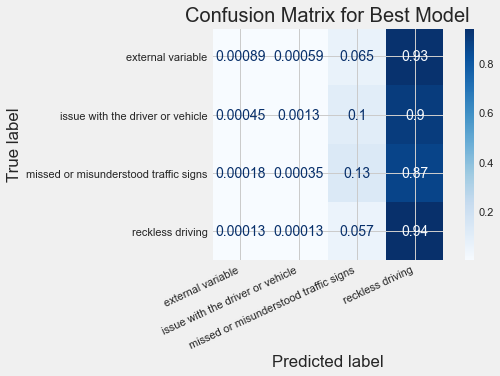

In [356]:

# Assuming pipe1 is your best model and X_test, y_test are your test sets
plt.figure(figsize=(10, 8))
plot_confusion_matrix(pipe4, X_test, y_test, cmap=plt.cm.Blues, normalize='true')

plt.title('Confusion Matrix for Best Model', fontsize=20)
plt.xticks(rotation=25, horizontalalignment='right')
plt.show()

# Creating new lists for categorical and numeric columns

In [357]:
#looking at column names and data types to help create categorical and numeric columns lists
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213988 entries, 12 to 731904
Data columns (total 58 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   PERSON_TYPE                    213988 non-null  object 
 1   SEX                            213988 non-null  object 
 2   EJECTION                       213988 non-null  object 
 3   INJURY_CLASSIFICATION          213988 non-null  object 
 4   DRIVER_VISION                  213988 non-null  object 
 5   PHYSICAL_CONDITION             213988 non-null  object 
 6   POSTED_SPEED_LIMIT             213988 non-null  int64  
 7   TRAFFIC_CONTROL_DEVICE         213988 non-null  object 
 8   DEVICE_CONDITION               213988 non-null  object 
 9   WEATHER_CONDITION              213988 non-null  object 
 10  LIGHTING_CONDITION             213988 non-null  object 
 11  FIRST_CRASH_TYPE               213988 non-null  object 
 12  TRAFFICWAY_TYPE              

In [370]:
cat_cols = ['PERSON_TYPE', 'SEX', 'EJECTION', 'INJURY_CLASSIFICATION',
       'DRIVER_VISION', 'PHYSICAL_CONDITION',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 
       'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
       'REPORT_TYPE', 'CRASH_TYPE', 'DAMAGE', 
        'STREET_DIRECTION', 
       'STREET_NAME', 'MOST_SEVERE_INJURY',
        'UNIT_TYPE', 'MAKE', 'MODEL', 'LIC_PLATE_STATE',
        'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE',
       'TRAVEL_DIRECTION', 'MANEUVER', 'FIRST_CONTACT_POINT',
       'BAC_RESULT', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED']
num_cols = ['AGE', 'STREET_NO', 'VEHICLE_YEAR', 'CRASH_HOUR',
            'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'BEAT_OF_OCCURRENCE', 'POSTED_SPEED_LIMIT',
            'LATITUDE', 'LONGITUDE', 'OCCUPANT_CNT',
            'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING',
            'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT',
            'INJURIES_NO_INDICATION', 'NUM_UNITS', 'INJURIES_UNKNOWN']

#got rid of 'FIRST_CRASH_TYPE' due to data leakage concerns

In [371]:
#checking out value counts for numeric columns
for column in df2[num_cols].columns:
    print(f"Column: {column}")
    print(df2[column].value_counts())
    print("\n")

Column: AGE
25.0     7017
27.0     6741
24.0     6711
26.0     6689
23.0     6636
         ... 
100.0       3
101.0       2
98.0        1
108.0       1
104.0       1
Name: AGE, Length: 105, dtype: int64


Column: STREET_NO
1600     1605
100      1509
800      1364
200      1305
300      1203
         ... 
5587        1
7571        1
9952        1
12407       1
8727        1
Name: STREET_NO, Length: 9788, dtype: int64


Column: VEHICLE_YEAR
2015.0    14801
2016.0    14124
2014.0    13706
2017.0    13389
2013.0    12665
          ...  
1965.0        1
1964.0        1
1960.0        1
1957.0        1
1952.0        1
Name: VEHICLE_YEAR, Length: 65, dtype: int64


Column: CRASH_HOUR
16    16593
15    16349
17    16090
14    14245
13    13000
18    12966
12    12929
8     12587
11    11893
9     10791
10    10585
7      9927
19     9237
20     7389
21     6576
22     5863
23     5166
6      4852
0      4073
1      3207
2      2792
5      2624
3      2234
4      2020
Name: CRASH_HOUR, dtype: i

In [372]:
#checking out value counts for categorical columns
for column in df2[cat_cols].columns:
    print(f"Column: {column}")
    print(df2[column].value_counts())
    print("\n")

Column: PERSON_TYPE
DRIVER                 213975
NON-CONTACT VEHICLE        11
NON-MOTOR VEHICLE           2
Name: PERSON_TYPE, dtype: int64


Column: SEX
M    133526
F     80245
X       217
Name: SEX, dtype: int64


Column: EJECTION
NONE                  209774
UNKNOWN                 3408
TOTALLY EJECTED          504
PARTIALLY EJECTED        159
TRAPPED/EXTRICATED       143
Name: EJECTION, dtype: int64


Column: INJURY_CLASSIFICATION
NO INDICATION OF INJURY     198868
NONINCAPACITATING INJURY      9159
REPORTED, NOT EVIDENT         4100
INCAPACITATING INJURY         1755
FATAL                          106
Name: INJURY_CLASSIFICATION, dtype: int64


Column: DRIVER_VISION
NOT OBSCURED              130027
UNKNOWN                    72131
OTHER                       4499
MOVING VEHICLES             2817
PARKED VEHICLES             2066
WINDSHIELD (WATER/ICE)      1163
BLINDED - SUNLIGHT           769
TREES, PLANTS                209
BUILDINGS                    155
BLINDED - HEADLIGHTS 

DID NOT DEPLOY                            138713
NOT APPLICABLE                             40733
DEPLOYED, FRONT                            12745
DEPLOYMENT UNKNOWN                         11461
DEPLOYED, COMBINATION                       7504
DEPLOYED, SIDE                              2688
DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)       144
Name: AIRBAG_DEPLOYED, dtype: int64




# Now lets go back to modeling

In [373]:
#making pipeline for numeric and categorical columns
numeric_pipeline = Pipeline([('numnorm', StandardScaler())])

nominal_pipeline = Pipeline([
    ('onehotenc', OneHotEncoder(sparse = False, handle_unknown = 'ignore')), 
    ('onehotnorm', MaxAbsScaler())])

In [374]:
#applying pipelines via column transformer to columns
ct = ColumnTransformer(
    [ ("nominalpipe", nominal_pipeline, cat_cols),
      ("numericpipe", numeric_pipeline, num_cols)
    ])

In [380]:
#checking how many columns were made
X.shape

(213988, 57)

In [376]:
#train test split before modeling, ensuring all is in order
X = df2.drop('target_mapped', axis=1)
y = df2['target_mapped']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic regression

In [377]:
#logistic regression modelusing many different columns
pipe = Pipeline([('preprocess', ct), 
                     ('model',
                        LogisticRegression(solver = 'liblinear'))])
pipe.fit(X_train, y_train)
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  ['PERSON_TYPE', 'SEX',
                                                   'EJECTION',
                                                   'INJURY_CLASSIFICATION',
                                                   'DRIVER_VISION',
                                                   'PHYSICAL_CONDITION',
                                                   'TRAFFIC_CONTROL_DEVICE',
                        

In [378]:
#score improved a good bit
print(pipe.score(X_train,y_train))
pipe.score(X_test,y_test)

0.687516794205269


0.6793775410065891

In [379]:
# Get predictions
y_pred = pipe.predict(X_test)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report (includes precision, recall, and F1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC Score
y_pred_proba = pipe.predict_proba(X_test)
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'))

Confusion Matrix:
[[ 1254    66   495  1547]
 [  131  1569   452  2323]
 [  239   130  5846  5062]
 [  446   535  2296 20407]]
Classification Report:
                                       precision    recall  f1-score   support

                    external variable       0.61      0.37      0.46      3362
     issue with the driver or vehicle       0.68      0.35      0.46      4475
missed or misunderstood traffic signs       0.64      0.52      0.57     11277
                     reckless driving       0.70      0.86      0.77     23684

                             accuracy                           0.68     42798
                            macro avg       0.66      0.53      0.57     42798
                         weighted avg       0.67      0.68      0.66     42798

ROC AUC Score:
0.8014626114933219


<Figure size 720x576 with 0 Axes>

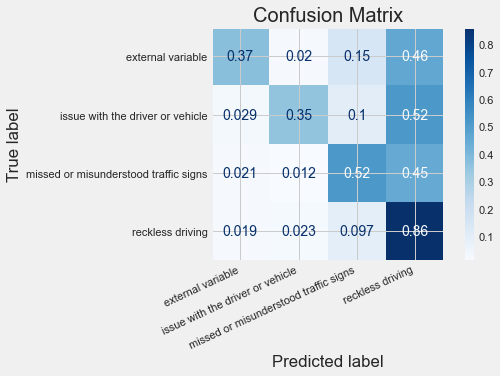

In [382]:
# confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(pipe, X_test, y_test, cmap=plt.cm.Blues, normalize='true')

plt.title('Confusion Matrix', fontsize=20)
plt.xticks(rotation=25, horizontalalignment='right')
plt.show()

## Random forest

In [385]:
#random forest classifier model
#max depth set to 20 so that it isnt too overfit but still performs somewhat well
pipe2 = Pipeline([
     ('preprocess', ct), 
     ('model', RandomForestClassifier(max_depth=20))
 ])

pipe2.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  ['PERSON_TYPE', 'SEX',
                                                   'EJECTION',
                                                   'INJURY_CLASSIFICATION',
                                                   'DRIVER_VISION',
                                                   'PHYSICAL_CONDITION',
                                                   'TRAFFIC_CONTROL_DEVICE',
                        

In [386]:
print(pipe2.score(X_train,y_train))
pipe2.score(X_test,y_test)

0.672095332671301


0.635029674283845

In [390]:
# Get predictions
y_pred = pipe2.predict(X_test)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report (includes precision, recall, and F1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC Score
y_pred_proba = pipe2.predict_proba(X_test)
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'))

Confusion Matrix:
[[  422     5   279  2656]
 [   21   597   207  3650]
 [    2    22  3623  7630]
 [   19   108  1021 22536]]
Classification Report:
                                       precision    recall  f1-score   support

                    external variable       0.91      0.13      0.22      3362
     issue with the driver or vehicle       0.82      0.13      0.23      4475
missed or misunderstood traffic signs       0.71      0.32      0.44     11277
                     reckless driving       0.62      0.95      0.75     23684

                             accuracy                           0.64     42798
                            macro avg       0.76      0.38      0.41     42798
                         weighted avg       0.68      0.64      0.57     42798

ROC AUC Score:
0.7945848198332259


<Figure size 720x576 with 0 Axes>

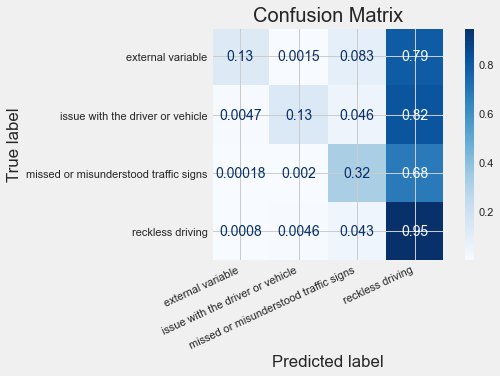

In [391]:
# confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(pipe2, X_test, y_test, cmap=plt.cm.Blues, normalize='true')

plt.title('Confusion Matrix', fontsize=20)
plt.xticks(rotation=25, horizontalalignment='right')
plt.show()

In [202]:
# Get the feature importances for random forest model
feature_importances = pipe2.named_steps['model'].feature_importances_

importances = pd.Series(feature_importances, index=all_feature_names)
importances = importances.abs().sort_values(ascending=False)
importances.head(60)

NUM_UNITS                                      0.042643
TRAFFIC_CONTROL_DEVICE_STOP SIGN/FLASHER       0.039306
MANEUVER_TURNING LEFT                          0.036151
INJURIES_NO_INDICATION                         0.032730
CRASH_TYPE_INJURY AND / OR TOW DUE TO CRASH    0.027924
MANEUVER_ENTERING TRAFFIC LANE FROM PARKING    0.021385
CRASH_TYPE_NO INJURY / DRIVE AWAY              0.021375
REPORT_TYPE_ON SCENE                           0.018312
TRAFFIC_CONTROL_DEVICE_NO CONTROLS             0.017311
REPORT_TYPE_NOT ON SCENE (DESK REPORT)         0.016878
TRAFFICWAY_TYPE_FOUR WAY                       0.016471
MANEUVER_BACKING                               0.015353
PHYSICAL_CONDITION_IMPAIRED - ALCOHOL          0.014684
PHYSICAL_CONDITION_NORMAL                      0.013525
DEVICE_CONDITION_FUNCTIONING PROPERLY          0.013471
DEVICE_CONDITION_NO CONTROLS                   0.012528
TRAFFIC_CONTROL_DEVICE_TRAFFIC SIGNAL          0.012169
FIRST_CONTACT_POINT_FRONT                      0

## XGBoost model

In [203]:
#xgboost model
pipe1 = Pipeline([('preprocess', ct), 
                 ('model', XGBClassifier(eval_metric='logloss'))])

pipe1.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  ['PERSON_TYPE', 'SEX',
                                                   'EJECTION',
                                                   'INJURY_CLASSIFICATION',
                                                   'DRIVER_VISION',
                                                   'PHYSICAL_CONDITION',
                                                   'TRAFFIC_CONTROL_DEVICE',
                        

In [204]:
#best so far, albeit a bit overfit
print(pipe1.score(X_train,y_train))
pipe1.score(X_test,y_test)

0.7327355569834687


0.7048226552642647

In [298]:
pipe1.score(X,y)
#overall score

0.727152924463054

In [211]:
# Get predictions
y_pred = pipe1.predict(X_test)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report (includes precision, recall, and F1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC Score
y_pred_proba = pipe1.predict_proba(X_test)
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'))
#note, chatgpt helped me with getting these scores in a nice format
# it particularly helped with formatting this and finding the classification report tool
# also helped with setting multi_class= and average= parameters

Confusion Matrix:
[[ 1403    82   435  1442]
 [  164  1623   399  2289]
 [  164    95  6574  4444]
 [  453   547  2119 20565]]
Classification Report:
                                       precision    recall  f1-score   support

                    external variable       0.64      0.42      0.51      3362
     issue with the driver or vehicle       0.69      0.36      0.48      4475
missed or misunderstood traffic signs       0.69      0.58      0.63     11277
                     reckless driving       0.72      0.87      0.78     23684

                             accuracy                           0.70     42798
                            macro avg       0.68      0.56      0.60     42798
                         weighted avg       0.70      0.70      0.69     42798

ROC AUC Score:
0.831514925694558


<Figure size 720x576 with 0 Axes>

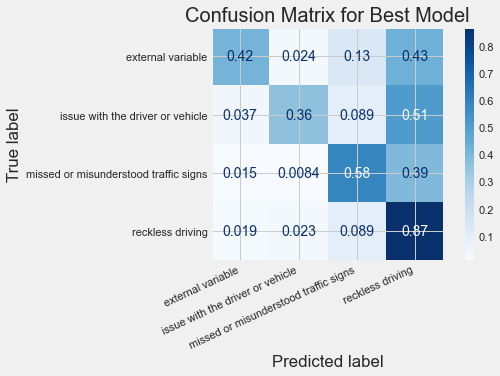

In [297]:
#Confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(pipe1, X_test, y_test, cmap=plt.cm.Blues, normalize='true')

plt.title('Confusion Matrix for Best Model', fontsize=20)
plt.xticks(rotation=25, horizontalalignment='right')
plt.show()

In [291]:
# feature importances for best model
feature_importances = pipe1.named_steps['model'].feature_importances_

importances = pd.Series(feature_importances, index=all_feature_names)
importances_main_model = importances.abs().sort_values(ascending=False)
importances_main_model[20:50]


DRIVER_VISION_PARKED VEHICLES             0.007455
INJURIES_NO_INDICATION                    0.007400
DRIVER_VISION_BLINDED - SUNLIGHT          0.007388
BAC_RESULT_TEST NOT OFFERED               0.006870
DRIVER_VISION_OTHER                       0.006662
MANEUVER_AVOIDING VEHICLES/OBJECTS        0.006560
VEHICLE_DEFECT_UNKNOWN                    0.005577
MANEUVER_CHANGING LANES                   0.005359
ROADWAY_SURFACE_COND_WET                  0.005198
DRIVER_VISION_MOVING VEHICLES             0.005103
MANEUVER_SKIDDING/CONTROL LOSS            0.005047
AIRBAG_DEPLOYED_DEPLOYED, SIDE            0.005029
MANEUVER_U-TURN                           0.005023
DRIVER_VISION_WINDSHIELD (WATER/ICE)      0.005022
FIRST_CONTACT_POINT_FRONT                 0.004905
TRAFFIC_CONTROL_DEVICE_NO CONTROLS        0.004803
MANEUVER_SLOW/STOP IN TRAFFIC             0.004643
FIRST_CONTACT_POINT_REAR                  0.004629
MANEUVER_STARTING IN TRAFFIC              0.004539
REPORT_TYPE_ON SCENE           

# Visualizations

## Bar Charts

In [392]:
#want to create a visualization for this
df2['target_mapped'].value_counts()

reckless driving                         118410
missed or misunderstood traffic signs     57137
issue with the driver or vehicle          21942
external variable                         16499
Name: target_mapped, dtype: int64

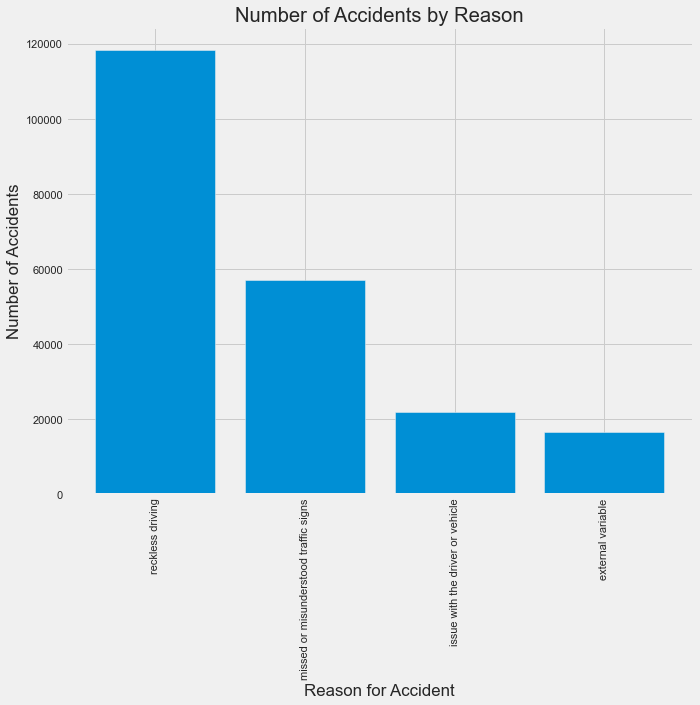

In [395]:
value_counts = df2['target_mapped'].value_counts()

fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(value_counts.index, value_counts.values)

ax.set_ylabel('Number of Accidents')
ax.set_xlabel('Reason for Accident')
plt.title('Number of Accidents by Reason')
plt.xticks(rotation=90) 

plt.show()


In [285]:
importances_main_model.head(100)

MANEUVER_ENTERING TRAFFIC LANE FROM PARKING    0.036869
PHYSICAL_CONDITION_IMPAIRED - ALCOHOL          0.029790
TRAFFIC_CONTROL_DEVICE_STOP SIGN/FLASHER       0.029137
MANEUVER_ENTER FROM DRIVE/ALLEY                0.025829
MANEUVER_TURNING LEFT                          0.023425
                                                 ...   
MAKE_UNKNOWN                                   0.001459
TRAFFICWAY_TYPE_T-INTERSECTION                 0.001446
TRAVEL_DIRECTION_E                             0.001427
UNIT_TYPE_PARKED                               0.001403
TRAFFIC_CONTROL_DEVICE_LANE USE MARKING        0.001386
Length: 100, dtype: float32

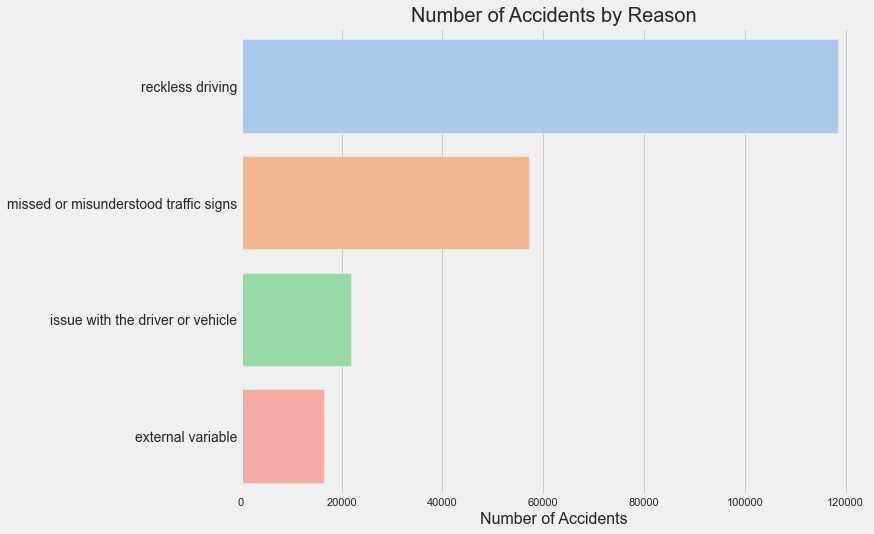

In [398]:
# Set seaborn aesthetic parameters to defaults
sns.set_theme()

# Set a specific background style
plt.style.use('fivethirtyeight')

# Increase the figure size
plt.figure(figsize=(10, 8))

# Get the value counts
value_counts = df2['target_mapped'].value_counts()

# Create a barplot
sns.barplot(y=value_counts.index, x=value_counts.values, palette="pastel")

# Add labels and title
plt.xlabel('Number of Accidents', fontsize=16)
plt.title('Number of Accidents by Reason', fontsize=20)

# Change the font size of the labels for each bar
y_ticks = plt.yticks()
plt.setp(y_ticks[1], size=14)

# Show the plot
plt.show()

#here i asked chatgpt various ways to make the plot look better and tuned it based on the methods it offered
#specifically, using seaborn, using fivethirtyeight, and having palette being pastel were my favorite combination

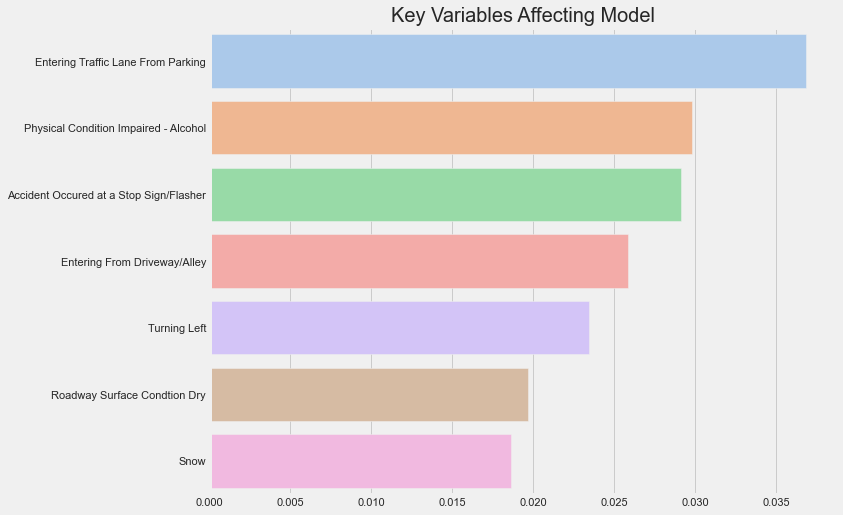

In [401]:
# copied most code from previous bar chart
# changing it to show the 7 most important variables affecting the best model

# Set seaborn aesthetic parameters to defaults
sns.set_theme()

# Set a specific background style
plt.style.use('fivethirtyeight')

# Increase the figure size
plt.figure(figsize=(10, 8))

# Get the value counts
importances_main_model_head = importances_main_model.head(7)

# Create a barplot
sns.barplot(y=importances_main_model_head.index, x=importances_main_model_head.values, palette="pastel")

# Add labels and title
plt.title('Key Variables Affecting Model', fontsize=20)

# creating a list of new labels
new_labels = ['Entering Traffic Lane From Parking', 'Physical Condition Impaired - Alcohol', 
              'Accident Occured at a Stop Sign/Flasher', 'Entering From Driveway/Alley', 
              'Turning Left', 'Roadway Surface Condtion Dry', 'Snow']

# Set the y-axis tick labels
plt.yticks(ticks=range(len(new_labels)), labels=new_labels)
plt.setp(y_ticks[1], size=20)

# Show the plot
plt.show()

# used similar code as to the previous bar graph, as i want to keep things consistent
# also needed to relabel the y ticks as they were poorly labeled
# also had to look up how to do this part: plt.yticks(ticks=range(len(new_labels)), labels=new_labels)

## Pie Charts

In [222]:
# want to see the difference between overall likelihood of primary cause 
# vs the likelihood of primary cause within the most relevant subgroups (the factors that affected the model the most)
df2[df2['TRAFFIC_CONTROL_DEVICE'] == 'STOP SIGN/FLASHER']['target_mapped'].value_counts()

missed or misunderstood traffic signs    14317
reckless driving                          8267
external variable                         1954
issue with the driver or vehicle          1563
Name: target_mapped, dtype: int64

In [220]:
#one of the most important variables that affected the model
df2[df2['PHYSICAL_CONDITION'] == 'IMPAIRED - ALCOHOL']['target_mapped'].value_counts()

issue with the driver or vehicle         2399
reckless driving                          640
missed or misunderstood traffic signs     191
external variable                          17
Name: target_mapped, dtype: int64

In [221]:
#one of the most important variables that affected the model
df2[df2['MANEUVER'] == 'ENTERING TRAFFIC LANE FROM PARKING']['target_mapped'].value_counts()

missed or misunderstood traffic signs    3425
reckless driving                          977
issue with the driver or vehicle          398
external variable                         135
Name: target_mapped, dtype: int64

In [228]:
#one of the most important variables that affected the model
df2[df2['WEATHER_CONDITION'] == 'SNOW']['target_mapped'].value_counts()

reckless driving                         3579
external variable                        3405
missed or misunderstood traffic signs    1580
issue with the driver or vehicle          631
Name: target_mapped, dtype: int64

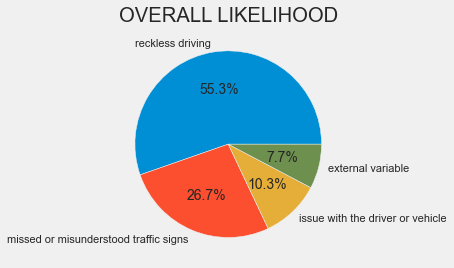

In [240]:
# overall likelihood pie chart
total_counts = df2['target_mapped'].value_counts()
total_counts.plot.pie(autopct='%1.1f%%')
plt.title('OVERALL LIKELIHOOD')
plt.ylabel('') # removing the default y label
plt.show()

#this is very much not pretty imo

In [301]:
palette = sns.color_palette('pastel', n_colors=len(df2['target_mapped'].unique()))
color_mapping = {category: color for category, color in zip(df2['target_mapped'].unique(), palette)}
def get_colors(counts):
    return [color_mapping[category] for category in counts.index]

#again using resources to make pie chart more visually appealing
#specifically, i wanted to make sure that the colors stay the same across all four pie charts

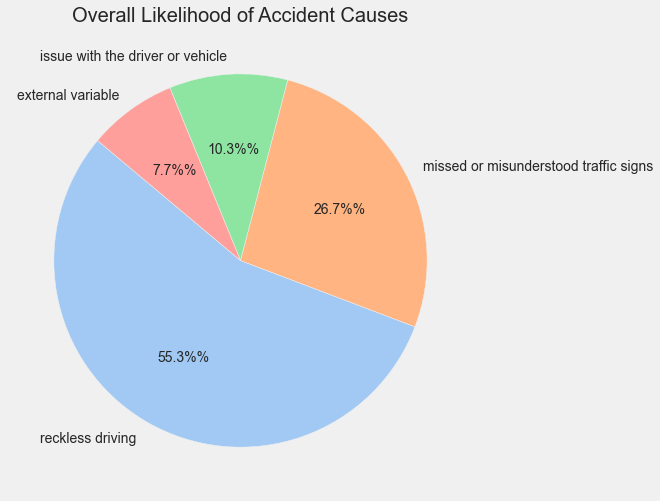

In [403]:
# for overall likelihood of accident causes
sns.set_theme()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 8))
total_counts = df2['target_mapped'].value_counts()
colors = sns.color_palette('pastel')[:len(total_counts)]
plt.pie(total_counts, labels=total_counts.index, autopct=lambda p:f'{p:.1f}%%', startangle=140, colors=colors, textprops={'fontsize': 14})
plt.title('Overall Likelihood of Accident Causes', fontsize=20)
plt.ylabel('') # removing the default y label
plt.show()

#sticking with the same style and color palette to stay consistent
# this line i needed help with, as I was struggling to get the colors to stay the same for each pie chart:
# plt.pie(total_counts, labels=total_counts.index, autopct=lambda p:f'{p:.1f}%%', startangle=140, colors=colors, textprops={'fontsize': 14})

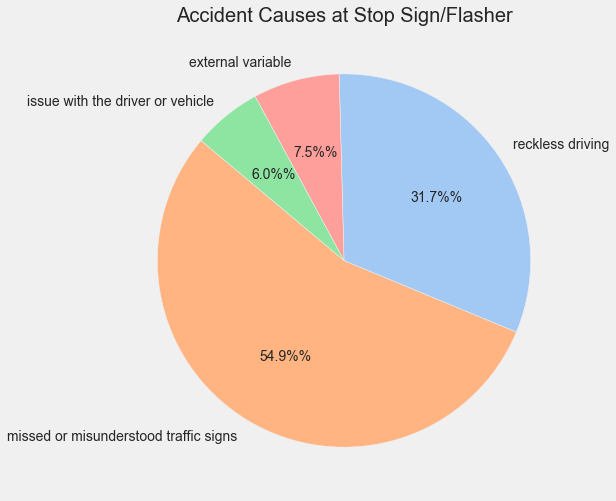

In [302]:
# stop sign/flasher pie chart
sns.set_theme()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 8))
stop_sign_counts = df2[df2['TRAFFIC_CONTROL_DEVICE'] == 'STOP SIGN/FLASHER']['target_mapped'].value_counts()
colors = get_colors(stop_sign_counts)
plt.pie(stop_sign_counts, labels=stop_sign_counts.index, autopct=lambda p:f'{p:.1f}%%', startangle=140, colors=colors, textprops={'fontsize': 14})
plt.title('Accident Causes at Stop Sign/Flasher', fontsize=20)
plt.ylabel('') # removing the default y label
plt.show()

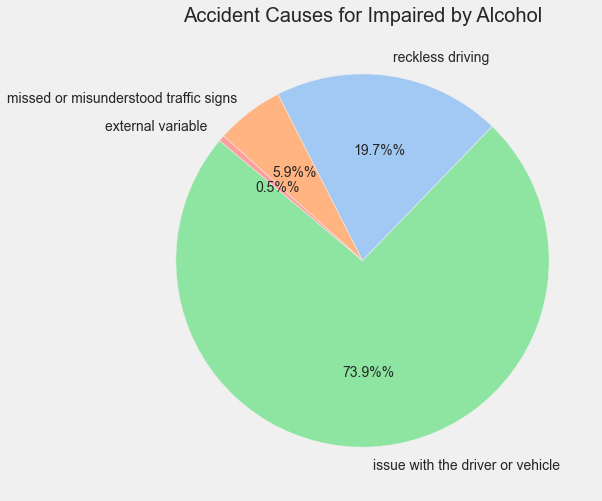

In [308]:
# alcohol impaired pie chart
sns.set_theme()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 8))
impaired_alcohol_counts = df2[df2['PHYSICAL_CONDITION'] == 'IMPAIRED - ALCOHOL']['target_mapped'].value_counts()
colors = get_colors(impaired_alcohol_counts)
plt.pie(impaired_alcohol_counts, labels=impaired_alcohol_counts.index, autopct=lambda p:f'{p:.1f}%%', startangle=140, colors=colors, textprops={'fontsize': 14})
plt.title('Accident Causes for Impaired by Alcohol', fontsize=20)
plt.ylabel('') # removing the default y label
plt.show()

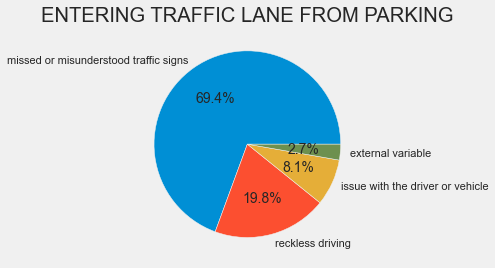

In [405]:
# enterring traffic counts pie chart
entering_traffic_counts = df2[df2['MANEUVER'] == 'ENTERING TRAFFIC LANE FROM PARKING']['target_mapped'].value_counts()
entering_traffic_counts.plot.pie(autopct='%1.1f%%')
plt.title('ENTERING TRAFFIC LANE FROM PARKING')
plt.ylabel('') # removing default y label
plt.show()
#again not very pretty, but still wanted to see

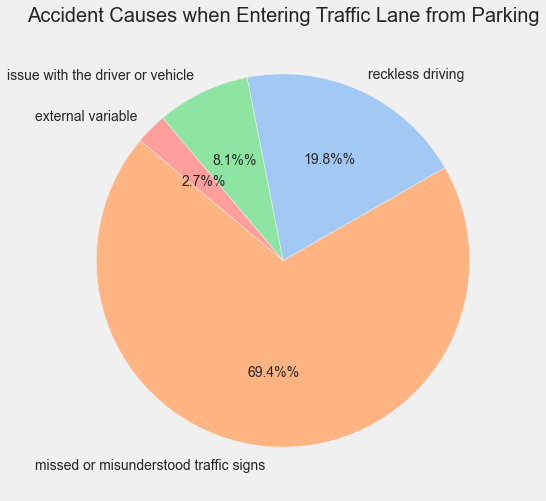

In [309]:

# ENTERING TRAFFIC LANE FROM PARKING pie chart
sns.set_theme()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 8))
entering_traffic_counts = df2[df2['MANEUVER'] == 'ENTERING TRAFFIC LANE FROM PARKING']['target_mapped'].value_counts()
colors = get_colors(entering_traffic_counts)
plt.pie(entering_traffic_counts, labels=entering_traffic_counts.index, autopct=lambda p:f'{p:.1f}%%', startangle=140, colors=colors, textprops={'fontsize': 14})
plt.title('Accident Causes when Entering Traffic Lane from Parking', fontsize=20)
plt.ylabel('') # removing the default y label
plt.show()

